##### Estadisticas generales sobre el covid-19

In [1]:
import numpy as np

from utilidades import *

data = load_data()
x = range(len(data[0]))

##### Casos

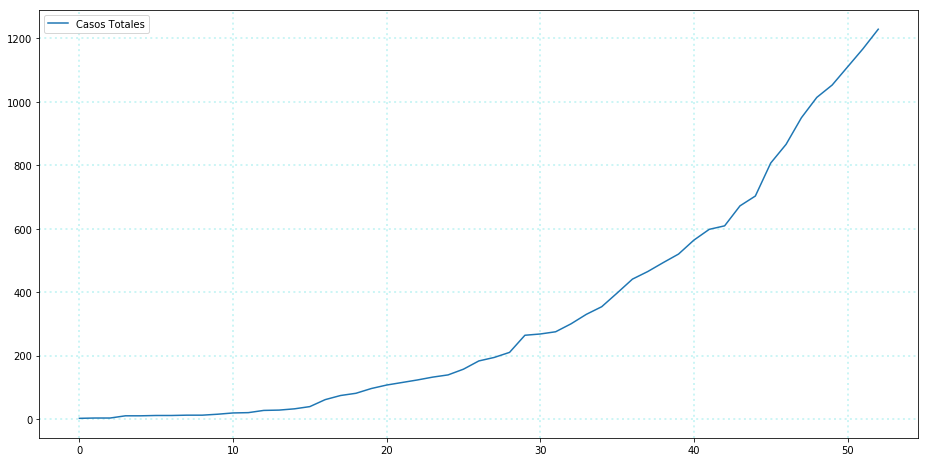

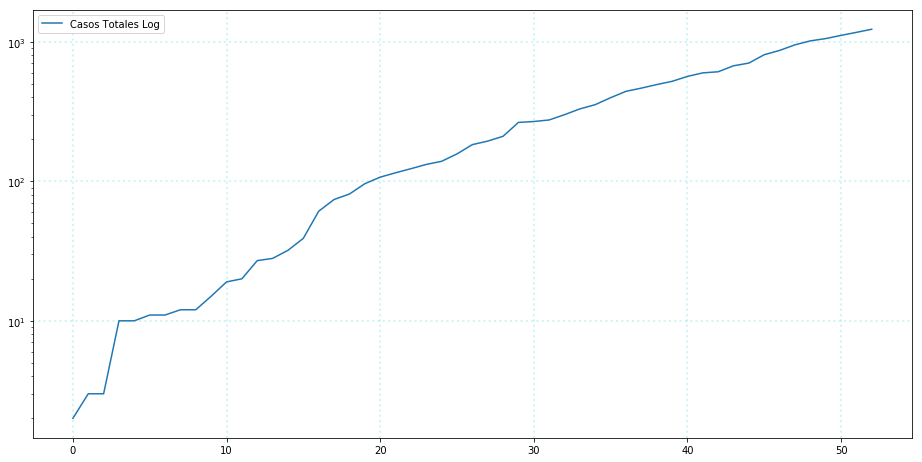

In [2]:
plot(x, data[1], labels=['Casos Totales'])
ax = plot(x, data[1], labels=['Casos Totales Log'])
ax.set_yscale('log')

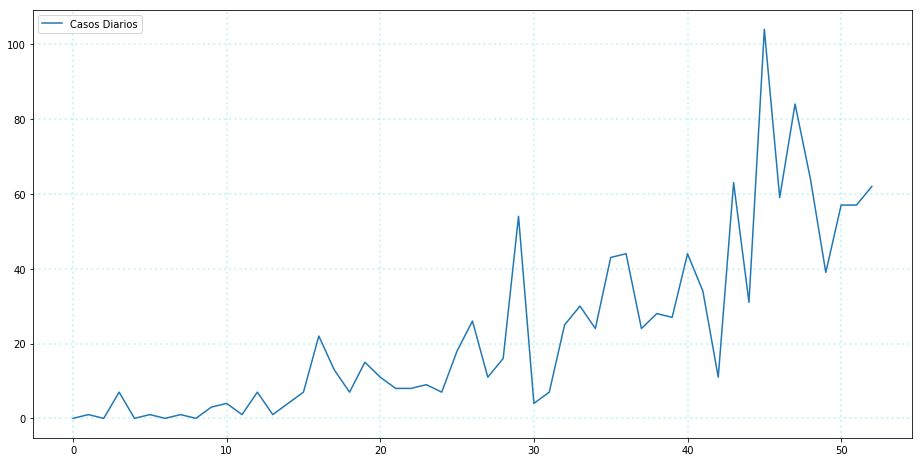

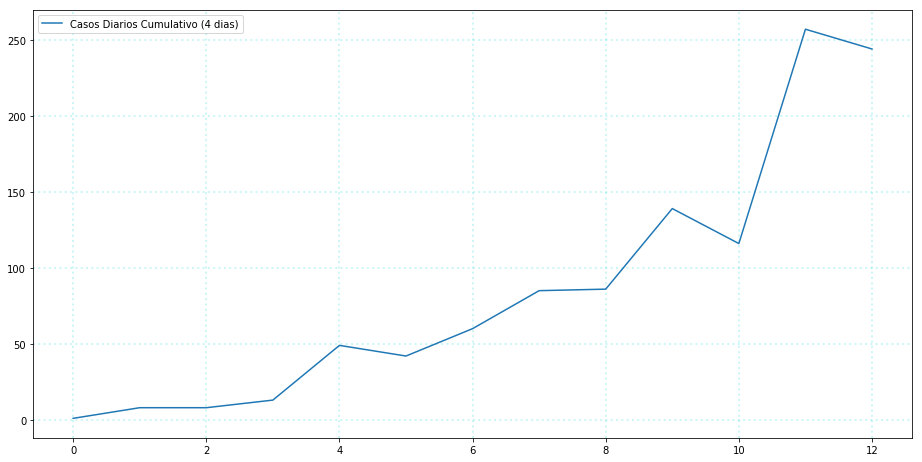

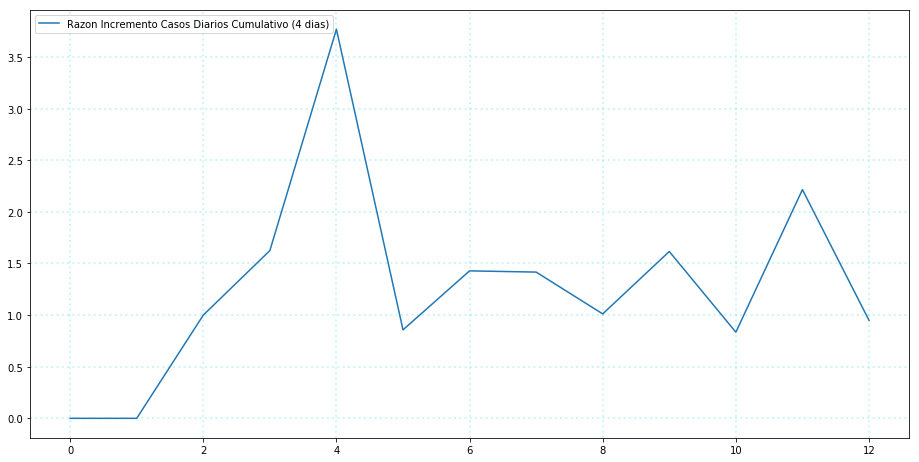

In [3]:
new_cases = np.diff(data[1], prepend=[data[1][0]])
plot(x, new_cases, labels=['Casos Diarios'])

pad_cases = np.pad(new_cases, (len(new_cases) % 4, 0), 'constant', constant_values=(0,))
cum_cases = [sum(pad_cases[_ * 4:(_ + 1) * 4]) for _ in range(int(len(pad_cases) / 4))]
plot(range(len(cum_cases)), cum_cases, labels=['Casos Diarios Cumulativo (4 dias)'])

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 4 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 4 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 4 dias (muy preocupante)
inc_cases = [0] * 2 + [cum_cases[_ + 1] / cum_cases[_] for _ in range(1, len(cum_cases) - 1)]
_ = plot(range(len(inc_cases)), inc_cases, labels=['Razon Incremento Casos Diarios Cumulativo (4 dias)'])

##### Fallecidos

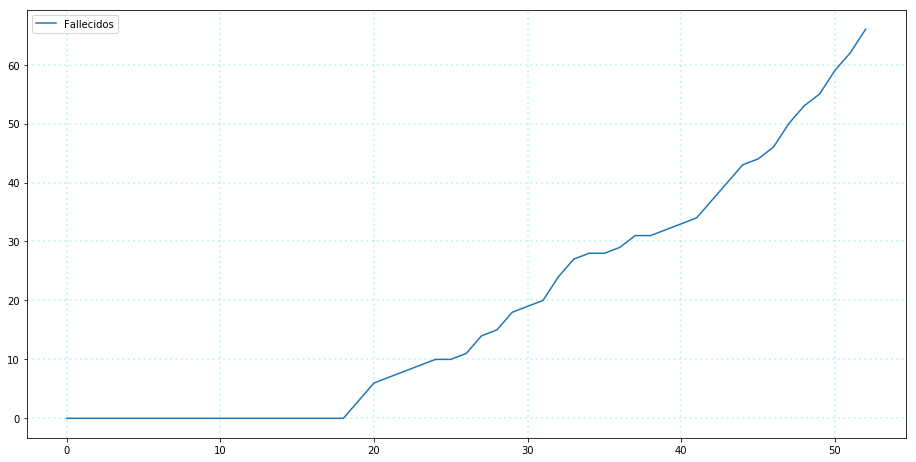

In [4]:
_ = plot(x, data[2], labels=['Fallecidos'])

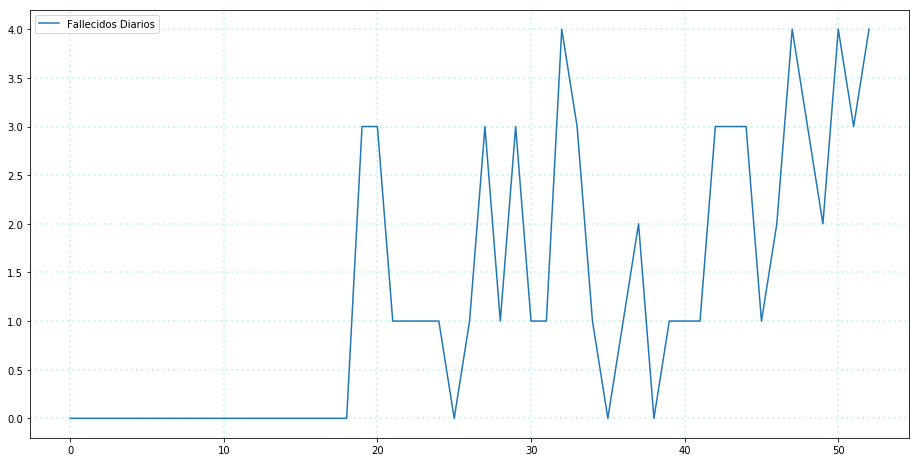

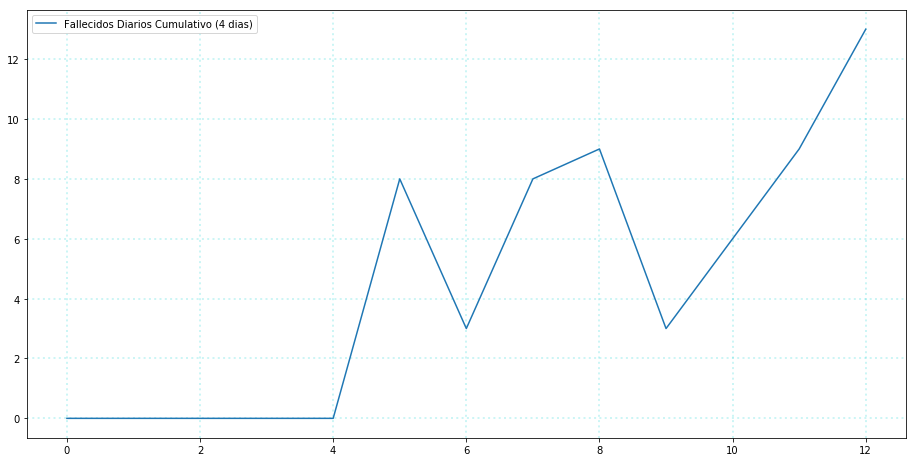

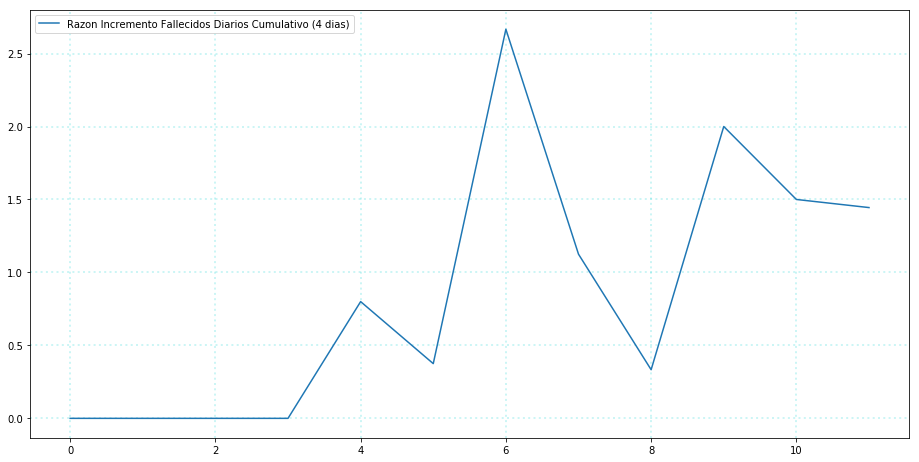

In [9]:
new_deaths = np.diff(data[2], prepend=[data[2][0]])
plot(x, new_deaths, labels=['Fallecidos Diarios'])

pad_deaths = np.pad(new_deaths, (len(new_deaths) % 4, 0), 'constant', constant_values=(0,))
cum_deaths = [sum(pad_deaths[_ * 4:(_ + 1) * 4]) for _ in range(int(len(pad_deaths) / 4))]
plot(range(len(cum_deaths)), cum_deaths, labels=['Fallecidos Diarios Cumulativo (4 dias)'])

# Si menor a 1, los casos se estan reduciendo (perfecto)
# Si entre 1 y 2, los casos se estan duplicado en mas de 4 dias (mas o menos, depende cuan cerca este al 1)
# Si igual a 2, los casos se estan duplicando cada 4 dias (preocupante)
# Si mayor a 2, los casos se estan duplicando en menos de 4 dias (muy preocupante)
inc_deaths = [cum_deaths[_ + 1] / (cum_deaths[_] or 10.) for _ in range(len(cum_deaths) - 1)]
_ = plot(range(len(inc_deaths)), inc_deaths, labels=['Razon Incremento Fallecidos Diarios Cumulativo (4 dias)'])

##### Tests

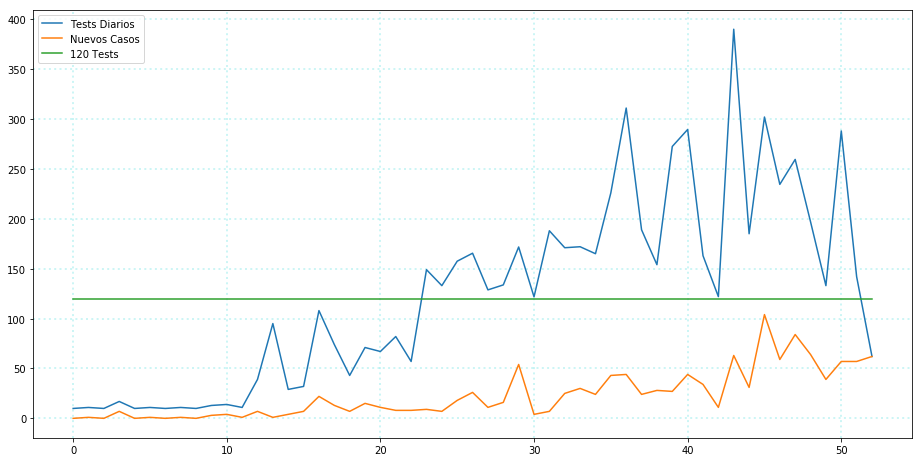

In [6]:
_ = plot(x, data[-1], new_cases, [120] * len(x), labels=['Tests Diarios', 'Nuevos Casos', '120 Tests'])

Tests Diarios = <a href='https://github.com/mauforonda/covid19-bolivia/blob/master/descartados.csv'>Descartados</a> + <a href='https://github.com/mauforonda/covid19-bolivia2/blob/master/nacional.csv'>Nuevos Casos</a>
Como referencia el 04/24, en el <a href='https://www.boliviasegura.gob.bo/comunicados_proc.php?Seleccion=23'>reporte del ministerio</a> indica que '4.490 casos fueron descartados mediante pruebas de laboratorio', misma cantidad que esta en los datos compilados por <a href='https://github.com/mauforonda'>@mauforonda</a>.  
Esto no concuerda con las declaraciones del ministro Navajas de que <a href='https://www1.abi.bo/abi_/?i=448936'>actualmente Bolivia cuenta con la capacidad de procesar en promedio de entre 115 a 120 pruebas diarias de laboratorio</a>, asi que esto queda como curiosidad mas que como dato.

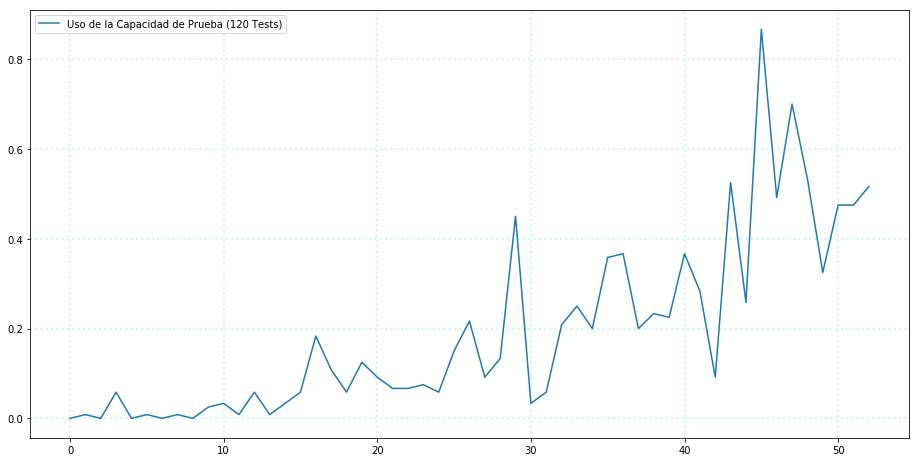

In [7]:
_ = plot(x, new_cases / np.array([120] * len(x)), labels=['Uso de la Capacidad de Prueba (120 Tests)'])

Esto es casos detectados por dia / 120 tests por dia

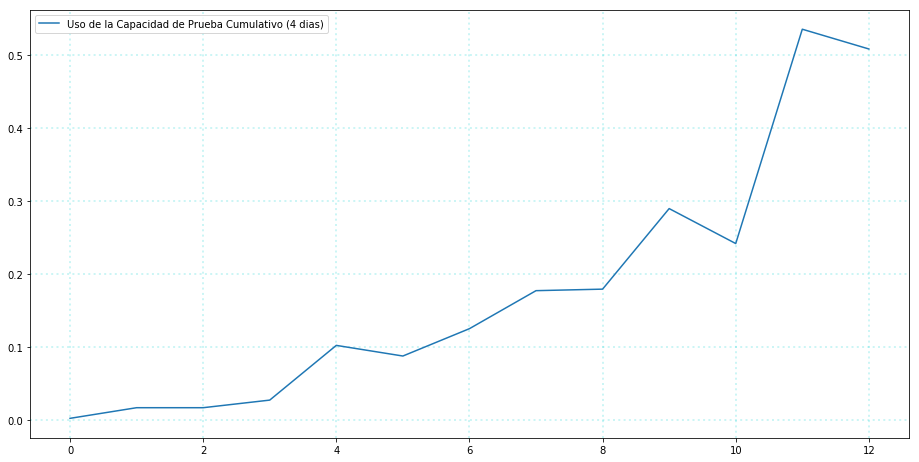

In [8]:
test_120_capacity = [_ / 480. for _ in cum_cases]
_ = plot(range(len(test_120_capacity)), test_120_capacity, labels=[
    'Uso de la Capacidad de Prueba Cumulativo (4 dias)'
])

Esto es un acumulado de los casos cada 4 dias / 120 tests por dia por 4 dias.